# Geometric Embedding in PersonLab

keypoints coordiantes:
 [[[ 28 228   1]
  [161 361   1]
  [ 55 455   1]
  [ 64  54   1]
  [368 550   1]]] 
pair wise keypoints:
 [[0, 1], [1, 2], [2, 4], [3, 4]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


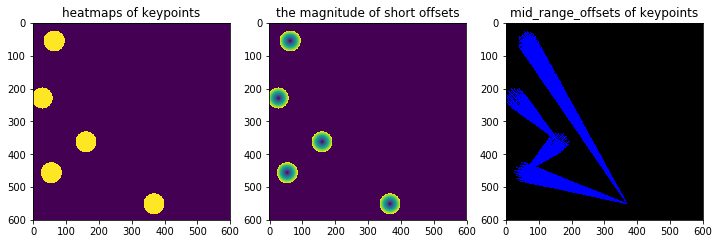

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def kpts_maps(keypoints_skeletons,discs,map_shape,kpts_num=17):
    # discs.shape N*kpts_num*[indices of the specified keypoint]
    kpts_maps = np.zeros(map_shape+(kpts_num,))

    for n in range(len(discs)):
        for k in range(kpts_num):
            #print(keypoints_skeletons[n,k,2])
            if keypoints_skeletons[n,k,2] > 0.:

                disk_indices = discs[n][k]
                kpts_maps[disk_indices,k] = 1.0

    return kpts_maps

def short_offsets(keypoints_skeletons,discs,map_shape,kpts_num=17):

    # discs.shape N*kpts_num*[indices of the specified keypoint]
    #disk_mask_map = np.zeros(shape=map_shape+(kpts_num,),dtype='bool')
    short_offsets = np.zeros(map_shape+(kpts_num,2,))
    #map_shape = (H, W)
    # [H,W,2]  for each pixel's (x,y) position index
    pixels_indices = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))

    for n in range(len(discs)):
        for k in range(kpts_num):
            if keypoints_skeletons[n,k,2] > 0:

                disk_indices = discs[n][k]

                short_offsets[disk_indices,k,0:2] = \
                    pixels_indices[disk_indices] - keypoints_skeletons[n][k,0:2]
                



    return short_offsets

def mid_range_offsets(pair_wise_kpts,keypoints_skeletons,discs,map_shape,kpts_num=17):
    """
    pair_wisd_kpts: for COCO, edges of tree structures of body is `kpts_num-1`
    such as [[kpt_shoulder_r,kpt_ankle_r],[kpt_shoulder_r,nose],..,[]]

    discs.shape Number of people*kpts_num*[disk indices of the specified keypoint]

    return [H,W,2*(kpts_num-1),2]
    """
    directed_edges = []
    for edge in pair_wise_kpts:
        directed_edges.append(edge)
        #directed_edges.append(edge[::-1])

    mid_offsets = np.zeros(map_shape+(len(directed_edges),2,))

    # [H,W,2]  for each pixel's (x,y) position index
    pixels_indices = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))

    for n in range(len(discs)):
        for edge_id, direct_edge in enumerate(directed_edges):
            begin_kpt_id, end_kpt_id = direct_edge
            begin_kpt = keypoints_skeletons[n][begin_kpt_id]
            end_kpt = keypoints_skeletons[n][end_kpt_id]

            if begin_kpt[2] > 0 and end_kpt[2] >0:
                disk_indices = discs[n][begin_kpt_id]
                #print(end_kpt[0],pixels_indices[disk_indices])
                mid_offsets[disk_indices,edge_id,0:2] = end_kpt[0:2]-pixels_indices[disk_indices,0:2]
                
                #print(mid_offsets[disk_indices,edge_id])
    return mid_offsets

def long_range_offsets(instance_masks, keypoints_skeletons, map_shape, kpts_num):
    """
    instance_masks: [N, H, W]
    keypoints_skeletons: [N,K,3]
    """
    assert instance_masks.shape[1:] == map_shape
    assert len(instance_masks)==len(keypoints_skeletons)

    long_offsets = np.zeros(shape=map_shape+(kpts_num,2,))
    
    for n in range(len(instance_masks)):
        mask_indices = instance_masks[n] > 0.
        for k in range(kpts_num):
            
            if keypoints_skeletons[n][k,2] > 0:
                # [H,W,2]  for each pixel's (x,y) position index
                pixels_indices = np.rollaxis(
                    np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))
                #kpt_x, kpt_y = keypoints_skeletons[n][k,0:2]
                long_offsets[mask_indices,k,0:2] = \
                    keypoints_skeletons[n][k,0:2] - pixels_indices[mask_indices]
    
    return long_offsets

def get_keypoint_discs(all_keypoints,map_shape,kpts_num=17,radius=4):
    """This function is borrowed from:
    https://github.com/octiapp/KerasPersonLab/blob/32d44dd1f33377128a87d6e074cf8214224f0174/data_prep.py#L27"""
    idx = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))

    discs = [[] for _ in range(len(all_keypoints))]
    for i in range(kpts_num):

        centers = [keypoints[i,:2] for keypoints in all_keypoints if keypoints[i,2] > 0]
        dists = np.zeros(map_shape+(len(centers),))

        for k, center in enumerate(centers):
            dists[:,:,k] = np.sqrt(np.square(center-idx).sum(axis=-1))
        if len(centers) > 0:
            inst_id = dists.argmin(axis=-1)
        count = 0
        for j in range(len(all_keypoints)):
            if all_keypoints[j][i,2] > 0:
                discs[j].append(np.logical_and(inst_id==count, dists[:,:,count]<=radius))
                count +=1
            else:
                discs[j].append(np.array([]))

    # discs.shape N*kpts_num*[indices of the specified keypoint]
    discs = np.array(discs)
    return discs

def visualize():

    #keypoints_skeletons1 = np.array([[[28,28,1],[61,61,1],[155,155,1]],[[20,20,1],[55,55,1],[6,6,1]]])
    keypoints_skeletons = np.array(
        [
        [[28,228,1],[161,361,1],[55,455,1],[64,54,1],[368,550,1]],
        #[[20,120,1],[55,55,1],[6,6,1]]
        ]
        )
        
    pair_wise_kpts = [[0,1],[1,2],[2,4],[3,4]]
    print("keypoints coordiantes:\n",keypoints_skeletons,"\npair wise keypoints:\n",pair_wise_kpts)

    map_shape = (600,600)
    kpts_num = 5
    radius = 32

    discs = get_keypoint_discs(keypoints_skeletons,map_shape,kpts_num,radius)
    
    kpts_heatmaps = kpts_maps(keypoints_skeletons,discs,map_shape,kpts_num)
    visual_kpts_heatmaps = np.amax(kpts_heatmaps,axis=-1)
    short = short_offsets(keypoints_skeletons,discs,map_shape,kpts_num)

    offsets_magnitude = np.sqrt(np.square(short).sum(axis=-1))
    visual_offsets_magnitude=np.max(offsets_magnitude,axis=-1)

    # show mid_range_offset
    mid_offsets = mid_range_offsets(pair_wise_kpts,
                                    keypoints_skeletons,
                                    discs,
                                    map_shape,
                                    kpts_num)

    
    #mid_offsets_edge = mid_offsets[:,:,0::2,:] # directed edges
    mid_offsets_edge = mid_offsets 			  # undirected edges

    mid_offsets_edge = mid_offsets_edge.astype('int')
    
    # (h,w,2)
    pixels_indices = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))
    
    # canvs
    background = np.zeros(map_shape+(3,))

    for n in range(len(discs)):
        for edge_id, edge in enumerate(pair_wise_kpts):
            if keypoints_skeletons[n,edge[0],2]>0 and keypoints_skeletons[n,edge[1],2] > 0:
                begin_disk_indices = discs[n][edge[0]]
                
                for (x,y) in pixels_indices[begin_disk_indices]:
                    # sparse disk setting for better visualization
                    if x %8==0 and y%8 ==0:
                        #continue
                        begin_kpt = (x,y)
                        # note: mid_offsets_edge[y,x,edge_id,0] not: mid_offsets_edge[x,y,edge_id,0]
                        end_kpt = (x + mid_offsets_edge[y,x,edge_id,0], y + mid_offsets_edge[y,x,edge[0],1])
                        
                        cv2.line(background,begin_kpt,end_kpt,(0,0,255),thickness=2)
                        
    fig = plt.figure(figsize=(12,12))
    fig.add_subplot(1,3,1)
    plt.imshow(visual_kpts_heatmaps )
    plt.title("heatmaps of keypoints")

    
    fig.add_subplot(1,3,2)
    plt.imshow(visual_offsets_magnitude)
    plt.title("the magnitude of short offsets")
    
    fig.add_subplot(1,3,3)
    plt.imshow(background)
    plt.title("mid_range_offsets of keypoints")
    
    #plt.savefig('visualization.png')
    plt.show()

    cv2.imshow("offset",cv2.resize(visual_offsets_magnitude,(600,600)))
    cv2.waitKey(3000)
    cv2.imshow("mid_offset",background)#cv2.resize(background,(1200,1200)))
    cv2.waitKey(30000)

if __name__ == '__main__':

    visualize()
